# TASK: 01
# Facial Expression Recognition System
In this task, I am going to implement a __Facial Expression Recognition System__ that leverages LLM encoder for feature extraction. We will see how this approach enhances the performance of the system on the __FER 2013__ dataset.

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

2024-07-22 11:08:55.560766: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 11:08:55.560831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 11:08:55.562560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## FER 2013 Dataset
This dataset contains __28 x 28__ grayscale images belonging to __7 classes__:
- angry
- disgust
- fear
- happy
- neutral
- sad
- surprise

In [6]:
class FER2013Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
        self.images, self.labels = self._load_dataset()

    def _load_dataset(self):
        images = []
        labels = []
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                images.append(img_path)
                labels.append(class_idx)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # CLIP expects 224x224
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = FER2013Dataset('/kaggle/input/fer2013/train',
                               transform=transform)
test_dataset = FER2013Dataset('/kaggle/input/fer2013/test',
                              transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,)

Number of training samples: 28709
Number of test samples: 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


In [8]:
image, label = next(iter(train_loader))
image.shape, label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [9]:
class FERModel(nn.Module):
    def __init__(self, num_classes, device='cuda'):
        super(FERModel, self).__init__()
        self.clip_model = (CLIPModel.from_pretrained("openai/clip-vit-base-patch32").vision_model).to(device)
        self.classifier = (nn.Linear(768, num_classes)).to(device) # CLIP's output dimension is 768
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        with torch.no_grad():
            features = self.clip_model(x).last_hidden_state[:, 0, :]  # Use CLS token
        output = self.classifier(features)
        return output


In [10]:
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}")
    for batch_idx, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f"{running_loss/(batch_idx+1):.3f}",
            'Acc': f"{100.*correct/total:.2f}%"
        })
        
        # Log to TensorBoard (every 100 batches)
        if batch_idx % 100 == 99:
            writer.add_scalar('training loss', running_loss / 100, epoch * len(train_loader) + batch_idx)
            writer.add_scalar('training accuracy', 100. * correct / total, epoch * len(train_loader) + batch_idx)
            running_loss = 0.0
    
    return running_loss / len(train_loader), 100. * correct / total

In [11]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    average_loss = total_loss / len(test_loader)
    return average_loss, accuracy

In [12]:
model = FERModel(num_classes=7)  # 7 classes for FER2013
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
writer = SummaryWriter('/kaggle/working/runs/')

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [13]:
# Lists to store metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
best_accuracy = 0.0

checkpoint_dir = '/kaggle/working/models'
os.makedirs(checkpoint_dir, exist_ok=True)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, epoch)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Log to TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/test', test_acc, epoch)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print()
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

# Close TensorBoard writer
writer.close()

Evaluating: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]


Epoch 1/20:
Train Loss: 0.1070, Train Acc: 59.42%
Test Loss: 1.0079, Test Acc: 61.80%



Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]


Epoch 2/20:
Train Loss: 0.1017, Train Acc: 64.66%
Test Loss: 0.9638, Test Acc: 63.53%



Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.34it/s]


Epoch 3/20:
Train Loss: 0.1017, Train Acc: 65.76%
Test Loss: 0.9468, Test Acc: 63.61%



Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.14it/s]


Epoch 4/20:
Train Loss: 0.1012, Train Acc: 66.40%
Test Loss: 0.9387, Test Acc: 63.92%



Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.29it/s]


Epoch 5/20:
Train Loss: 0.0977, Train Acc: 66.85%
Test Loss: 0.9283, Test Acc: 64.59%

Checkpoint saved to /kaggle/working/models/model_epoch_5.pth


Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.31it/s]


Epoch 6/20:
Train Loss: 0.0952, Train Acc: 67.15%
Test Loss: 0.9234, Test Acc: 64.45%



Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.21it/s]


Epoch 7/20:
Train Loss: 0.0933, Train Acc: 67.59%
Test Loss: 0.9188, Test Acc: 64.77%



Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]


Epoch 8/20:
Train Loss: 0.0958, Train Acc: 67.68%
Test Loss: 0.9151, Test Acc: 65.53%



Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.25it/s]


Epoch 9/20:
Train Loss: 0.0893, Train Acc: 68.07%
Test Loss: 0.9174, Test Acc: 65.21%



Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.36it/s]


Epoch 10/20:
Train Loss: 0.0935, Train Acc: 68.09%
Test Loss: 0.9116, Test Acc: 65.21%

Checkpoint saved to /kaggle/working/models/model_epoch_10.pth


Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]


Epoch 11/20:
Train Loss: 0.0940, Train Acc: 68.32%
Test Loss: 0.9144, Test Acc: 65.52%



Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.26it/s]


Epoch 12/20:
Train Loss: 0.0926, Train Acc: 68.50%
Test Loss: 0.9135, Test Acc: 65.52%



Evaluating: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]


Epoch 13/20:
Train Loss: 0.0948, Train Acc: 68.51%
Test Loss: 0.9177, Test Acc: 65.39%



Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.30it/s]


Epoch 14/20:
Train Loss: 0.0924, Train Acc: 68.66%
Test Loss: 0.9089, Test Acc: 65.71%



Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.33it/s]


Epoch 15/20:
Train Loss: 0.0924, Train Acc: 68.75%
Test Loss: 0.9020, Test Acc: 65.52%

Checkpoint saved to /kaggle/working/models/model_epoch_15.pth


Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]


Epoch 16/20:
Train Loss: 0.0907, Train Acc: 68.94%
Test Loss: 0.9111, Test Acc: 65.37%



Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.33it/s]


Epoch 17/20:
Train Loss: 0.0932, Train Acc: 68.97%
Test Loss: 0.9097, Test Acc: 65.44%



Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]


Epoch 18/20:
Train Loss: 0.0921, Train Acc: 69.07%
Test Loss: 0.9039, Test Acc: 65.73%



Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.38it/s]


Epoch 19/20:
Train Loss: 0.0926, Train Acc: 69.11%
Test Loss: 0.9078, Test Acc: 64.92%



Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]


Epoch 20/20:
Train Loss: 0.0923, Train Acc: 69.21%
Test Loss: 0.9022, Test Acc: 65.39%

Checkpoint saved to /kaggle/working/models/model_epoch_20.pth


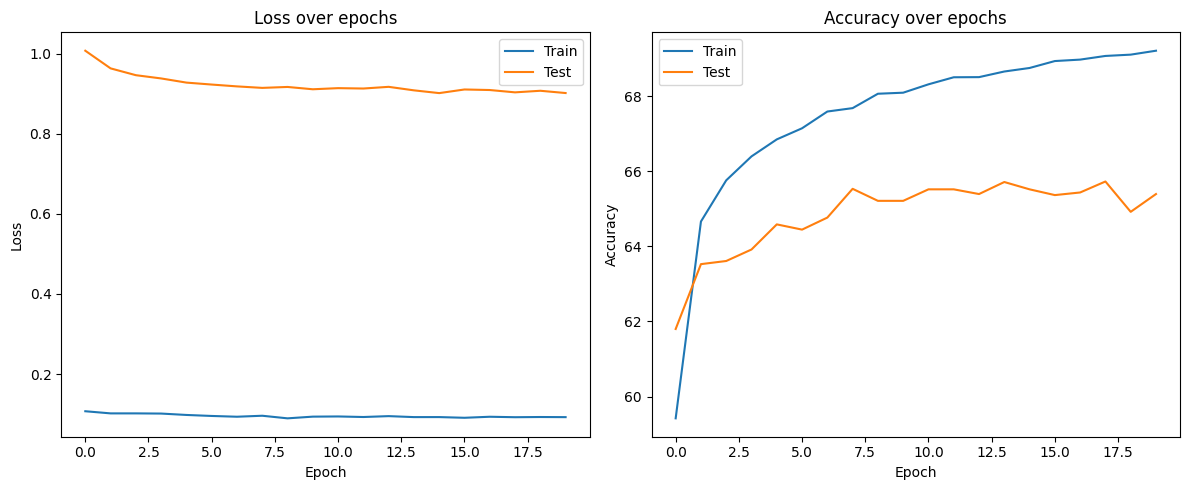

In [18]:
# Plot training and testing metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()


In [15]:
final_test_loss, final_test_acc = evaluate(model, test_loader, criterion, device)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")

# Save the model
torch.save(model.state_dict(), 'fer2013_model.pth')

Evaluating: 100%|██████████| 225/225 [00:35<00:00,  6.34it/s]


Final Test Accuracy: 65.39%
